# Current working stack for setting up PEST interface

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

### load the existing model just to see what is going on

In [2]:
nam_file = "freyberg.nam"
org_model_ws = "freyberg_sfr_update"
m = flopy.modflow.Modflow.load(nam_file,model_ws=org_model_ws,check=False)

In [3]:
m.dis.nper #stress periods

3

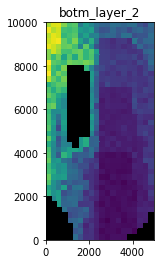

In [4]:
m.dis.botm[2].plot()

### change the working dir and write a new copy of model files to keep the others safe

In [5]:
m.change_model_ws("temp",reset_external=True)
m.external_path = '.'
m.exe_name="mfnwt"
m.write_input()
m.run_model()


changing model workspace...
   temp
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:botm_layer_1: resetting 'how' to external
Util2d:botm_layer_2: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:ibound_layer_1: resetting 'how' to external
Util2d:ibound_layer_2: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:strt_layer_1: resetting 'how' to external
Util2d:strt_layer_2: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vka: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vka: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vka: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:rech_1: resetting 'how' to 

(True, [])

### build up args for which properties and outputs we want to include in the interface

In [6]:
props,hds = [],[]
for k in range(m.nlay):
    #props.append(["upw.hk",k])
    #props.append(["upw.vka",k])
    for kper in range(m.nper):
        hds.append([kper,k])
    
#props.append(["rch.rech",0])
#props.append(["rch.rech",1])
props.append(["upw.hk",0])

### Here's where the cool stuff happens: this call will build a pest interace entirely using mulitplier parameters - a mixture of uniform (constant) and grid-scale parameters for all props listed above, plus multipliers for all wells in all stress periods and SFR components.  

### For observations, we will get the MODFLOW list file budget values, sfr outputs and headsave file array values (all of them!).  All observations will be given simulated outputs - this is very useful for error checking...

### The interface package will be written to "template" and includes a python forward run script - "template" is the whole package....

In [7]:
ph = pyemu.helpers.PstFromFlopyModel(nam_file,org_model_ws="temp",
                                     new_model_ws="template",pp_props=props,pp_space=3,
                                    const_props=None,all_wells=False,
                                    sfr_pars=False,hds_kperk=hds,
                                    remove_existing=True, sfr_obs=True,
                                    model_exe_name="mfnwt",build_prior=False)

2018-03-20 14:39:43.864463 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp\freyberg.nam
Setting filehandles:

--------------------------------------------------
External unit dictionary:
{2: filename:temp\freyberg.list, filetype:LIST, 11: filename:temp\freyberg.dis, filetype:DIS, 13: filename:temp\freyberg.bas, filetype:BAS6, 31: filename:temp\freyberg.upw, filetype:UPW, 19: filename:temp\freyberg.rch, filetype:RCH, 32: filename:temp\freyberg.nwt, filetype:NWT, 14: filename:temp\freyberg.oc, filetype:OC, 30: filename:temp\freyberg.lmt6, filetype:LMT6, 20: filename:temp\freyberg.wel, filetype:WEL, 17: filename:temp\freyberg.sfr, filetype:SFR, 50: filename:temp\freyberg.cbc, filetype:DATA(BINARY), 51: filename:temp\freyberg.hds, filetype:DATA(BINARY), 60: filename:temp\freyberg.sfr.out, filetype:DATA}
--------------------------------------------------

ModflowBas6 free format:True

loa

ValueError: dictionary update sequence element #0 has length 1; 2 is required

### let's inspect what just happened...

In [ ]:
pst = ph.pst

In [ ]:
pst.npar,pst.nobs

# WAT!

In [ ]:
pst.parameter_data.head()

In [ ]:
pst.observation_data.tail() # the last few observations

### write parameter and observtion summary LaTeX tables

In [ ]:
pst.write_par_summary_table()
pst.write_obs_summary_table()

### plot the prior distribution of the parameter implied by the parameter bounds (assuming bounds represent 95% credible limits)

In [ ]:
figs = pst.plot(kind="prior",unique_only=True,echo=False)

### but we can do better! We can use geostatistics to build a prior parameter covariance matrix for spatially distributed parameters...

In [ ]:
cov = ph.build_prior(fmt="none")

In [ ]:
plt.imshow(np.ma.masked_where(cov.x==0,cov.x))
plt.show()

### Let's run pestpp once to get residuals...which should be *nearly* zero since all observations are set to current simulated outputs and all parameters are multipliers - this is a good check!

In [ ]:
pyemu.helpers.run("pestpp freyberg.pst",cwd="template")

Reload the pst instance to update the residuals

In [ ]:
pst = pyemu.Pst(os.path.join("template","freyberg.pst"))

In [ ]:
pst.phi_components

### all residuals are *nearly* zero - this is good!

In [ ]:
pst.plot(kind='phi_pie')

### Let's do some Monte Carlo!

Generate a parameter ensemble and run it in parallel

In [ ]:
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=ph.pst,num_reals=100,
                                               cov=cov,use_homegrown=True,
                                                group_chunks=True)

In [ ]:
# save to a csv file
pe.to_csv(os.path.join("template","sweep_in.csv"))

In [ ]:
# run with sweep using 20 workers
pyemu.helpers.start_slaves("template","sweep","freyberg.pst",num_slaves=20,
                          master_dir="sweep_master")

### more eye candy using the plot helpers...

Every 50th parameters

In [ ]:
pyemu.plot_utils.ensemble_helper(pe.iloc[:,::50],facecolor='b',
                                 deter_vals=pst.parameter_data.parval1.to_dict(),
                                 filename=None) # you can also pass pdf filename

### load the output csv file....

In [ ]:
df = pd.read_csv(os.path.join("sweep_master","sweep_out.csv"))
df.columns = df.columns.map(str.lower)
df = df.loc[:,[o for o in pst.obs_names if "hds_00" in o ]]

### and plot...

In [ ]:
pyemu.plot_utils.ensemble_helper(df.iloc[:,:20],filename=None)